In [9]:
import sys
# This on is a path correcting code, which is used to find the path of qusim.
sys.path.append('../../../..')
import qusim.DataPlot.plot_lib as pl
import qusim.Instruments.tools as tools
import qusim.Instruments.stochastic_gen as sg
import qusim.System.arb_qubit_system as aqs
import qusim.Instruments.angle as  ang

import numpy as np
import matplotlib.pyplot as plt

from tqdm import *
from time import *
from sympy import*
import copy

from qutip import*

# Some useful tools
# Some intrinsic plotting function


def var_name2str(variable):
    def nested_var_name2str(value):
        if isinstance(value, list):
            return [nested_var_name2str(item) for item in value]
        else:
            for name in globals():
                if eval(name) == value:
                    return name
            return str(value)
    return nested_var_name2str(variable)

# Print the full output
np.set_printoptions(threshold=sys.maxsize)

# auto reload
%load_ext autoreload
%autoreload 2 

def get_angle(tstate, spt):
    if isket(spt):
        if isket(tstate):
            angle = np.angle(tstate.dag() * spt)[0][0]
    else:
        if isket(tstate):
            length = spt.dims[0][0]
            # print(length)
            # print(tstate.dims)
            # print(Qobj(np.insert(np.angle(spt.full()[0][1:length]), 0 ,0)).dims)
            angle_qobj = Qobj(np.insert(np.angle(spt.full()[0][1:length]), 0 ,0)).dag() * tstate
            angle = angle_qobj.full()[0][0]
        else: angle = None
    if angle <0:
        angle += 2*np.pi
    return angle

def phase_tracking(res, state):
    angle_list = []
    for spt in res.states:
        angle_list.append(get_angle(state, spt))
    return angle_list

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Two Data qubit
Referring to https://journals.aps.org/prb/pdf/10.1103/PhysRevB.90.045418

The effective Hamiltonian for two qubit is given by
$$
H_{eff} = (\mu \Delta_{12} + \bar{B}) \sigma_z^1 + (\mu \Delta_{34} + \bar{B}) \sigma_z^2 + J_{23}/4 (\sigma_z^1 \sigma_z^2 - II)
$$

Here, we reduce this to 

$$
H_{eff} = \omega_1 \sigma_z^1 + \omega_2 \sigma_z^2 + \chi \sigma_z^1 \sigma_z^2
$$


In [111]:
freq_list = [
    [0, 6.3],
    [0, 5.8]
]

inter_list = [
    {
        "v01": 0,
        "v00": 1,
        "v11": -1
    },
    {
        "v01": 0,
        "v00": 1,
        "v11": -1
    }
]

r_dic = {
    "r12": 1e-3
}
r = tools.r2matrix(r_dic, freq_list) # Coupling strength

extra_list = [
    {
        "v01": 0
    },
    {
        "v01": 0
    }
]

## with pulse type XY
driving_list = [
    {
        "W01": 1j   # W01 represents \Omega_{01}, for the qubit with index 0
    },
    {
        "W01": 1j
    }
]

## with pulse type Z
bias_list = [ # Default, Z00 = 0
    {
        "Z11": 1
    },
    {
        "Z11": 1
    }
]

gamma_list = [
    {
        'up': 0,
        'down': 0,
        'z': 4e-3
    },
    {
        'up': 0,
        'down': 0,
        'z': 5e-3
    }
]

gamma_list = None

_system_arb1 = aqs.arb_qubit_system(freq_list, inter_list, r, extra_list, gamma_list, driving_list, bias_list)

state_00, E_00, index_00 = _system_arb1.get_eigenstates_energy((0,0))
state_01, E_01, index_01 = _system_arb1.get_eigenstates_energy((0,1))
state_10, E_10, index_10 = _system_arb1.get_eigenstates_energy((1,0))
state_11, E_11, index_11 = _system_arb1.get_eigenstates_energy((1,1))

_system_arb1.H

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[6.28318531e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 3.64361916e+01 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 3.95777842e+01 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 7.60328254e+01]]

## Energy level
### Scan $\omega_2$

In [27]:
num_level = 4 # Num of level we want to see
w2_scan_space= np.linspace(5.5, 8, 800)
w =copy.deepcopy(freq_list)

energy_level_list = []
for w2 in w2_scan_space:
    dummy_list = []
    w[1][1] = w2
    _system_arb1 = aqs.arb_qubit_system(w, inter_list, r, extra_list, gamma_list, driving_list, bias_list)
    for j in range(0,num_level):
        dummy_list.append((_system_arb1.H.eigenenergies()[j] / np.pi/2).real)
    energy_level_list.append(dummy_list)

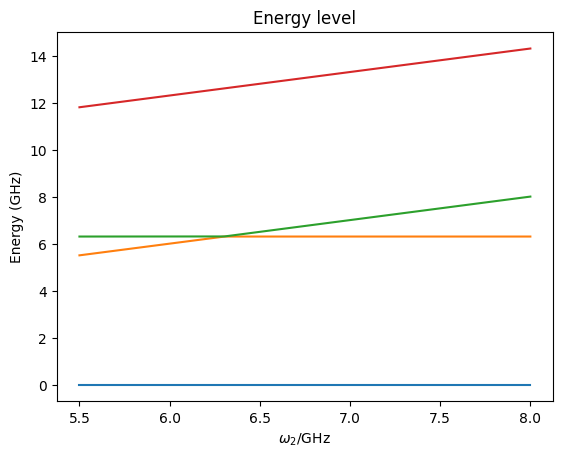

0

In [28]:
# %matplotlib qt
pl.plot_Elevel_dynamics(w2_scan_space, energy_level_list, 4, "\omega_2")

### Scan $\chi$

In [29]:
num_level = 4 # Num of level we want to see
chi_scan_space= np.linspace(0.1e-3, 200e-3, 800)
w =copy.deepcopy(freq_list)

energy_level_list = []
for chi in chi_scan_space:
    dummy_list = []
    rr_dic = {"r12": chi}
    rr = tools.r2matrix(rr_dic, freq_list) # Coupling strength

    _system_arb1 = aqs.arb_qubit_system(w, inter_list, rr, extra_list, gamma_list, driving_list, bias_list)
    for j in range(0,num_level):
        dummy_list.append((_system_arb1.H.eigenenergies()[j] / np.pi/2).real)
    energy_level_list.append(dummy_list)

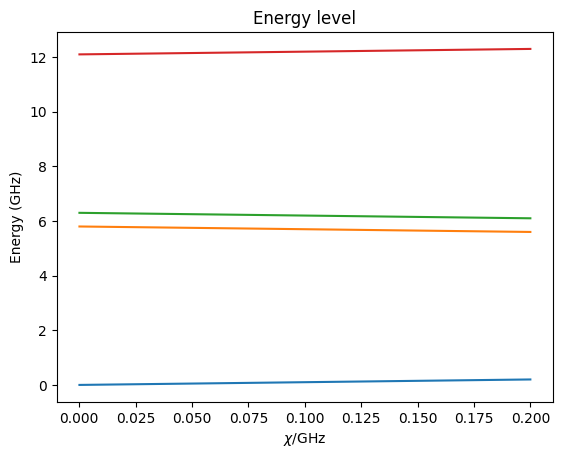

0

In [30]:
# %matplotlib qt
pl.plot_Elevel_dynamics(chi_scan_space, energy_level_list, 4, "\chi")

## System dynamics

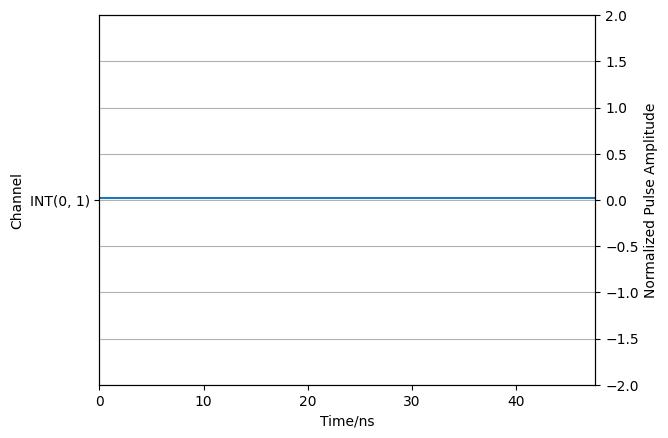

0

In [115]:
t_width = 0; bisa_amp = 20e-3
simulation_option = {
    "simulation_time": 1/(bisa_amp + r_dic["r12"]), # ns
    "simulation_step": 300,
    "initial_state": [state_00, state_01, state_10, state_11] # Do multiple simulation
}

pulse_sequence = [
    {
        'pulse_index': 1, # [m,n] represents $\Omega_{mn}$
        'type': "INT",
        'pulse_shape': "cosine",
        't_delay': 0, # unit in ns
        't_width': t_width, # unit in ns
        't_plateau':simulation_option['simulation_time'] - t_width , # unit in ns
        'freq': 0, # unit in GHz; Z pulse does not use it
        'phase': 0, # unit in rad; Z pulse does not use it
        'amplitude': bisa_amp, # XY: Rabi freq; Z: biased frequency
        'q_index': (0,1)
    }
]

%matplotlib inline
## Notice that the all pulses'  amplitude are rescaled by a factor 1/1.2
pl.plot_pulse_sequence(pulse_sequence, simulation_option)

In [116]:
result_list, angle_list = _system_arb1.system_dynamics_mesolve(simulation_option, pulse_sequence)
angle_list

[array([[0.0157849]]),
 array([[5.07064004]]),
 array([[6.26744787]]),
 array([[5.10234247]])]

In [97]:
result_list[2].states[-1]

Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[ 0.        +0.j        ]
 [ 0.        +0.j        ]
 [-0.91432152+0.40498909j]
 [ 0.        +0.j        ]]

In [117]:
prop_list = _system_arb1.system_dynamics_propagator(simulation_option, pulse_sequence)

25.0%. Run time:   1.03s. Est. time left: 00:00:00:03
50.0%. Run time:   1.06s. Est. time left: 00:00:00:01
75.0%. Run time:   1.07s. Est. time left: 00:00:00:00
100.0%. Run time:   1.10s. Est. time left: 00:00:00:00
Total run time:   1.14s


In [118]:
prop_list[-1]

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[0.99987542+0.01578424j 0.        +0.j         0.        +0.j
  0.        +0.j        ]
 [0.        +0.j         0.35063686-0.9365115j  0.        +0.j
  0.        +0.j        ]
 [0.        +0.j         0.        +0.j         0.99987617-0.01573679j
  0.        +0.j        ]
 [0.        +0.j         0.        +0.j         0.        +0.j
  0.3801454 -0.92492674j]]

In [ ]:
{"rt": 128,"tau_list": [500, 600, 30],"ep_list": [10,10, 1],"dBz": 3.85e-3,"trail": 8}